In [1]:
# Import what we need for the script.

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from EqW import *

In [2]:
# Create a function which generates a gaussian.

def gaussian(x, mu, sig, pwr):
    return pwr * (np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))))

In [3]:
# Define a continuum fit function.

def region_around_line(w, flux, cont, pf = 0):
    '''cut out and normalize flux around a line

    Parameters
    ----------
    w : 1 dim np.ndarray
        array of wanvelenghts
    flux : np.ndarray of shape (N, len(w))
        array of flux values for different spectra in the series
    cont : list of lists
        wavelengths for continuum normalization [[low1,up1],[low2, up2]]
        that described two areas on both sides of the line
    '''
    #index is true in the region where we fit the polynomial
    indcont = ((w > cont[0][0]) & (w < cont[0][1])) |((w > cont[1][0]) & (w < cont[1][1]))
    #index of the region we want to return
    indrange = (w > cont[0][0]) & (w < cont[1][1])
    fluxmean = np.mean(flux[:,np.where(indcont)])
    # make a flux array of shape
    # (nuber of spectra, number of pointsin indrange)
    f = np.zeros((flux.shape[0], indrange.sum()))
    for i in range(flux.shape[0]):
        # fit polynom of second order to the continuum region
        linecoeff = np.polyfit(w[indcont], flux[i, indcont], pf)
        # devide the flux by the polynom and put the result in our
        # new flux array
        f[i,:] = flux[i,indrange]/np.polyval(linecoeff, w[indrange])
    if fluxmean < 0:
        f = -f
    f = f - 1
    return w[indrange], f

In [4]:
# Define error functions for the optimisation of the gaussian fit. Penalise fits far from the Ha line using regularisation (check if this is appropriate).

def error(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.sum(np.power(flux - fit, 2.)) + 0.01 * np.power(mu - 4861, 2.)

def error2(data, flux, wavelength):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    fit = gaussian(wavelength, mu, sig, pwr)
    return np.power(flux - fit, 2.)

In [5]:
# Import the scipy.optimize.minimize function

from scipy.optimize import minimize

In [6]:
# Import SpectRes package to rebin the gaussian into the spectrum wavelength bins whilst conserving flux.

from spectres import spectres

In [7]:
# Define a new error function using SpectRes for the optimisation.

def reerr(data, w, f, gauw):
    mu, sig, pwr = data
    if sig < 1.8 or sig > 25:
        return np.inf
    res_fluxes = spectres(w, gauw, gaussian(gauw, mu, sig, pwr))
    return np.sum(np.power(f - res_fluxes, 2.)) + 0.1 * np.power(mu - 4861, 2.)

In [8]:
def halinefit(file, rang, quiet = False, cfit = 0):
    
    flux = np.load(file)
    wavelength = np.load('wavelength.npy')
    
    wha, fha = region_around_line(wavelength, np.reshape(flux, (1, np.size(flux))), rang, pf = cfit)
    fha = np.reshape(fha, np.size(wha))
    
    x0 = np.array((4861, 10, -5))
    gauw = np.linspace(rang[0][0]-10, rang[1][1]+10, 1000)
    res = minimize(reerr, x0, args=(wha, fha, gauw), method='Nelder-Mead', tol=1e-6)
    
    if not quiet:
        plt.plot(wha, fha)
        plt.plot(gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    res_spec = spectres(wha, gauw, gaussian(gauw, res.x[0], res.x[1], res.x[2]))
    
    if not quiet:
        plt.show()
    
    cont = fha - res_spec
    
    if not quiet:
        plt.plot(wha, cont)
        plt.show()
    
    ew = (np.sum(gaussian(gauw, res.x[0], res.x[1], res.x[2]))/res.x[2])*(gauw[1]-gauw[0])
    
    snr = np.abs(res.x[2]) / np.std(cont)
    
    if not quiet:
        print(res.x)
    
        print(np.std(cont))
    
        print(snr)
        
    quans = np.quantile(cont, [0.05, 0.95])
    
    return ew, snr, quans[0], quans[1]
    

In [9]:
rang = [[4800, 4840],[4875, 4900]]

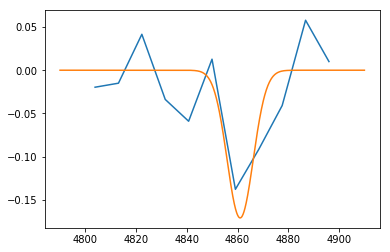

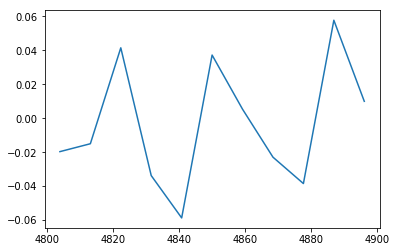

[ 4.86100724e+03  5.14303195e+00 -1.70822906e-01]
0.035253737968935085
4.845526058293314


(12.891669302123843,
 4.845526058293314,
 -0.04861162476904107,
 0.049663266373661225)

In [10]:
halinefit('v_e_20180704_32_1_0_2.npy', rang)

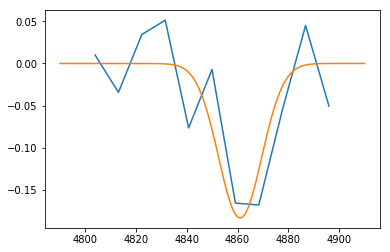

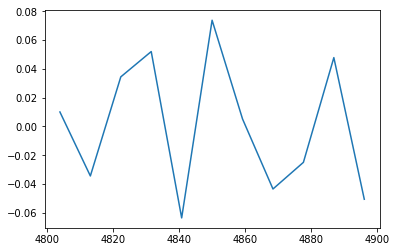

[ 4.86101272e+03  8.50972639e+00 -1.83321776e-01]
0.044707918924950234
4.100431879017243


(21.33072069033585,
 4.100431879017243,
 -0.05695973708538876,
 0.06286939092403368)

In [11]:
halinefit('v_e_20180704_32_2_0_2.npy', rang)

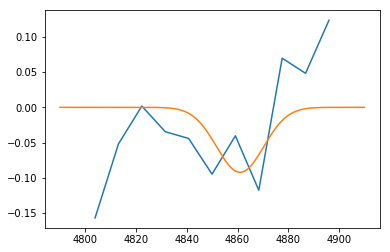

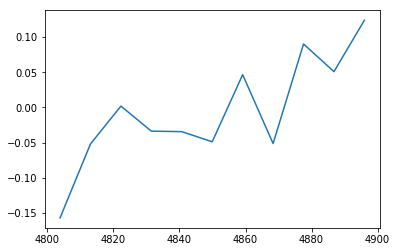

[ 4.86099634e+03  9.28328982e+00 -9.22402938e-02]
0.07538754725315508
1.2235481479324952


(23.269755277262824,
 1.2235481479324952,
 -0.10448468935990574,
 0.10694092970799571)

In [12]:
halinefit('v_e_20180704_32_3_0_2.npy', rang)

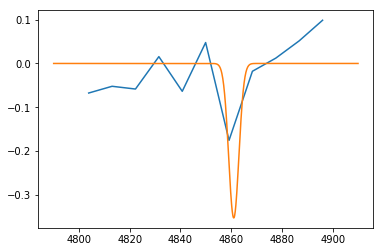

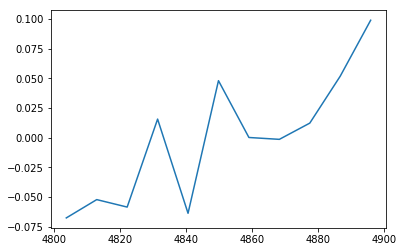

[ 4.86100033e+03  2.00434846e+00 -3.53217849e-01]
0.052120336976935036
6.776967866598266


(5.024156524783818,
 6.776967866598266,
 -0.06566743303504595,
 0.07526402206149763)

In [13]:
halinefit('v_e_20180704_38_1_0_2.npy', rang)

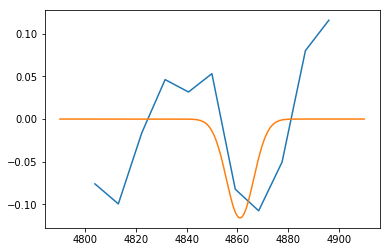

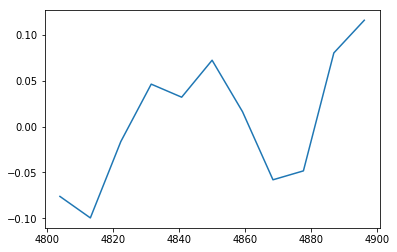

[ 4.86101142e+03  5.38514264e+00 -1.15935193e-01]
0.06726120879257524
1.7236561016088454


(13.498550800181999,
 1.7236561016088454,
 -0.087762280789246,
 0.09805169168469785)

In [14]:
halinefit('v_e_20180704_38_2_0_2.npy', rang)

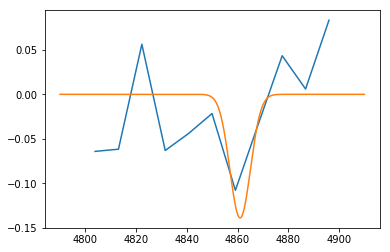

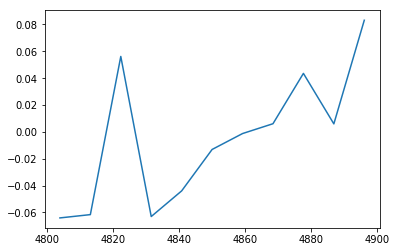

[ 4.86099855e+03  4.06166674e+00 -1.38699434e-01]
0.04839253542080245
2.866132823922409


(10.181088698263855,
 2.866132823922409,
 -0.06352527988281462,
 0.06966449328793248)

In [15]:
halinefit('v_e_20180704_38_3_0_2.npy', rang)